In [1]:
import pandas as pd
import numpy as np
import json
import os
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
sns.set_palette("colorblind")

# Data Loading

In [3]:
pwd = "."
figs_dir = "./figs"
!mkdir -p figs

In [4]:
APPENDIX_RESUTLS = True

In [5]:
nbs = [
  "lextoumbourou/feedback3-eda-hf-custom-trainer-sift",
  "paultimothymooney/kaggle-survey-2022-all-results",
  "dataranch/supermarket-sales-prediction-xgboost-fastai",
  "kkhandekar/environmental-vs-ai-startups-india-eda",
  "ampiiere/animal-crossing-villager-popularity-analysis",
  "aieducation/what-course-are-you-going-to-take",
  "saisandeepjallepalli/adidas-retail-eda-data-visualization",
  "joshuaswords/netflix-data-visualization",
  "spscientist/student-performance-in-exams",
  "ibtesama/getting-started-with-a-movie-recommendation-system",

  "nickwan/creating-player-stats-using-tracking-data",
  "erikbruin/nlp-on-student-writing-eda",
  "madhurpant/beautiful-kaggle-2022-analysis",
  "pmarcelino/comprehensive-data-exploration-with-python",
  "gksriharsha/eda-speedtests",
  "mpwolke/just-you-wait-rishi-sunak",
  "sanket7994/imdb-dataset-eda-project",
  "roopacalistus/retail-supermarket-store-analysis",
  "sandhyakrishnan02/indian-startup-growth-analysis",
  "josecode1/billionaires-statistics-2023"
]
nb_labels = [
  "feedb-eda-hf-sift",
  "kaggle-survey-2022",
  "sales-pred-xgboost",
  "env-ai-startups-eda",
  "animal-crossing",
  "course-prediction",
  "adidas-retail-eda",
  "netflix-data-viz",
  "student-perf",
  "movie-recomm",

  "player-stats-tracking",
  "nlp-stud-writ-eda",
  "kaggle-2022-analysis",
  "data-expl-with-python",
  "eda-speedtests",
  "just-you-wait-rishi-sunak",
  "imdb-dataset-eda",
  "smarket-store-analysis",
  "indian-startup-growth",
#   "eda-airline-dataset",
  "billionaires-statistics"
]

def only_hits_nb(df):
  global APPENDIX_RESUTLS
  if not APPENDIX_RESUTLS:
    assert (type(df) == pd.DataFrame or type(df) == pd.Series or type(df) == pd.Index)
    return df[:10]
  else:
    return df

def only_hits_cell(df):
  global APPENDIX_RESUTLS
  if not APPENDIX_RESUTLS:
    assert (type(df) == pd.DataFrame or type(df) == pd.Series)
    hits = [s for s in df.index if int(s.split('_')[1]) < 10]
    return df.loc[hits]
  else:
    return df

def ns_to_ms(ns):
  return ns / 1_000_000

num_runs = 10
len(nbs)

20

In [6]:
def read_stats(version, read_mem=True):
  cell_to_all_runs = {}
  nb_to_mem_runs = {}
  for nb_idx, nb in enumerate(nbs):
    for r in range(num_runs):
      nb_filename = '_'.join(nb.split('/')) + '.json'
      filepath = f"{pwd}/{version}/s-{r}/{nb_filename}"
      fp = open(filepath, 'r')
      d = json.load(fp)
      fp.close()
      nb_mem_key = f'NB_{nb_idx}'
      if read_mem:
        # Store Memory Results. One per notebook
        try:
          nb_to_mem_runs[nb_mem_key].append(d['max-mem-in-mb'])
        except:
          nb_to_mem_runs[nb_mem_key] = [d['max-mem-in-mb']]
      # Store timing results. One per cell.
      for c_idx, c in enumerate(d['cells']):
        key = f"C_{nb_idx}_{c_idx}"
        cell_time = ns_to_ms(c['total-ns'])
        try:
          cell_to_all_runs[key].append(cell_time)
        except:
          cell_to_all_runs[key] = [cell_time]

  ### Verify all cells have same number of timings ###
  keys = list(cell_to_all_runs)
  for i in range(len(keys)):
    for j in range(i+1, len(keys)):
      ki = keys[i]
      kj = keys[j]
      vi = cell_to_all_runs[ki]
      vj = cell_to_all_runs[kj]
      assert len(vi) == len(vj)

  time_df = pd.DataFrame(cell_to_all_runs)
  if read_mem:
    mem_df = pd.DataFrame(nb_to_mem_runs)
  else:
    mem_df = None
  return time_df, mem_df

In [7]:
def read_modin_stats(version):
  cell_to_all_runs = {}
  nb_to_mem_runs = {}
  for nb_idx, nb in enumerate(nbs):
    for r in range(num_runs):
      nb_filename = '_'.join(nb.split('/')) + '.json'
      nb_timing_filepath = f"{pwd}/{version}/s-{r}/{nb_filename}"
      timing_fp = open(nb_timing_filepath, 'r')
      timing_d = json.load(timing_fp)
      timing_fp.close()
      
      mem_split = version.split("_")
      mem_suff = mem_split[-1]
      assert mem_suff == "OFF"
      mem_suff = "ON"
      mem_version = "_".join(mem_split[:-1] + [mem_suff])
      nb_mem_filepath = f"{pwd}/{mem_version}/s-{r}/{nb_filename}"
      mem_fp = open(nb_mem_filepath, 'r')
      mem_d = json.load(mem_fp)
      mem_fp.close()
      
      
      nb_mem_key = f'NB_{nb_idx}'
      # Store Memory Results. One per notebook
      try:
        nb_to_mem_runs[nb_mem_key].append(mem_d['max-mem-in-mb'])
      except:
        nb_to_mem_runs[nb_mem_key] = [mem_d['max-mem-in-mb']]
      # Store timing results. One per cell.
      for c_idx, c in enumerate(timing_d['cells']):
        key = f"C_{nb_idx}_{c_idx}"
        cell_time = ns_to_ms(c['total-ns'])
        try:
          cell_to_all_runs[key].append(cell_time)
        except:
          cell_to_all_runs[key] = [cell_time]

  ### Verify all cells have same number of timings ###
  keys = list(cell_to_all_runs)
  for i in range(len(keys)):
    for j in range(i+1, len(keys)):
      ki = keys[i]
      kj = keys[j]
      vi = cell_to_all_runs[ki]
      vj = cell_to_all_runs[kj]
      assert len(vi) == len(vj)

  time_df = pd.DataFrame(cell_to_all_runs)
  mem_df = pd.DataFrame(nb_to_mem_runs)
  return time_df, mem_df

In [8]:
# All versions have the raw cells. Pick one at random and get the raw.
def find_raw(cell_name):
  spl = cell_name.split('_')
  search_nb_idx = int(spl[1])
  search_cell_idx = int(spl[2])
  nb = nbs[search_nb_idx]
  print(f"--- {nb} ---")
  nb_filename = '_'.join(nb.split('/')) + '.json'
  random_run = 4
  filepath = f"{pwd}/stats-rewr_OFF-modin_OFF-repl_STD-sliced_exec_ON/s-{random_run}/{nb_filename}"
  fp = open(filepath, 'r')
  d = json.load(fp)
  fp.close()
  for c_idx, c in enumerate(d['cells']):
    if c_idx == search_cell_idx:
      return c['raw']
  assert 0

# Rewriter vs Pandas

In [9]:
orig, _ = read_stats("stats-rewr_OFF-modin_OFF-repl_STD-modin_mem_OFF")
rewr, _ = read_stats("stats-rewr_ON-modin_OFF-repl_STD-modin_mem_OFF")

In [10]:
orig

,C_0_0,C_0_1,C_0_2,C_0_3,C_0_4,C_0_5,C_0_6,C_0_7,C_0_8,C_0_9,...,C_19_9,C_19_10,C_19_11,C_19_12,C_19_13,C_19_14,C_19_15,C_19_16,C_19_17,C_19_18
0,211.668543,73.763627,73.002557,0.408526,0.176132,0.171262,0.184143,171.934676,273.680820,309.014469,...,823.858707,16.732487,19.105987,0.291992,70.557745,2292.407763,2811.414582,0.393564,258.165185,5.276077
1,212.699649,73.802335,73.966894,0.399275,0.173782,0.170092,0.192452,172.515982,271.663915,310.944972,...,823.091280,16.743277,19.210320,0.289363,74.536606,2245.590653,2800.726569,0.377743,258.053405,5.593539
2,213.914843,74.773784,76.834751,0.408066,0.172562,0.169892,0.197653,175.811411,278.429922,314.354855,...,821.422222,16.750119,19.197129,0.290983,69.784241,2275.009548,2836.680658,0.390894,259.999813,5.361148
3,213.459771,74.192973,74.909234,0.408916,0.172492,0.169602,0.182132,173.464391,274.425780,317.654272,...,821.856052,16.727141,19.161662,0.251512,74.250317,2281.086503,2807.982376,0.383613,259.934725,5.713442
4,213.781021,73.926655,73.569699,0.406096,0.173882,0.171693,0.185212,174.819428,275.389033,312.485463,...,821.935000,16.726812,19.126213,0.294062,69.811363,2266.679346,2818.257554,0.390604,258.154948,5.308738
5,212.498512,74.018247,73.019845,0.403115,0.174752,0.171662,0.183522,171.644537,272.623780,317.628154,...,823.608397,16.631984,18.847031,0.244473,74.069476,2266.431809,2834.116187,0.365914,259.722083,5.714902
6,212.556041,73.769614,74.950709,0.396635,0.175263,0.169782,0.183613,172.999630,272.804737,317.941953,...,820.902617,16.746844,19.182016,0.286813,76.107542,2229.644597,2816.143189,0.366273,258.847585,5.660723
7,213.162579,73.701766,73.892428,0.399435,0.177323,0.171532,0.186032,171.746855,272.941605,314.820736,...,820.412235,16.735625,19.106548,0.284162,69.762888,2267.198432,2827.055009,0.393884,262.783311,5.269579
8,215.743213,74.335241,75.358634,0.406246,0.176112,0.176993,0.187902,173.748313,275.383745,312.714402,...,825.050279,16.760546,19.167209,0.291313,69.707261,2232.882046,2822.241841,0.393133,256.341058,5.308931
9,214.095520,74.152991,73.140666,0.405265,0.172912,0.169532,0.182363,173.518477,276.098178,313.490458,...,820.404703,16.733328,19.131730,0.290993,70.049731,2238.546459,2829.417078,0.377284,259.639338,5.246680


## Discard Very Fast Cells

In [11]:
cells_to_drop = []
for c in orig.columns:
  if orig[c].mean() < 50:
    orig = orig.drop(c, axis=1)
    rewr = rewr.drop(c, axis=1)
    cells_to_drop.append(c)

print(len(rewr.columns))

265


In [12]:
orig

,C_0_0,C_0_1,C_0_2,C_0_7,C_0_8,C_0_9,C_0_10,C_1_0,C_1_4,C_1_5,...,C_18_8,C_19_0,C_19_2,C_19_4,C_19_5,C_19_9,C_19_13,C_19_14,C_19_15,C_19_17
0,211.668543,73.763627,73.002557,171.934676,273.680820,309.014469,22899.541126,910.980727,2692.358768,91.402536,...,447.280572,859.355056,791.627352,1127.802859,55.972529,823.858707,70.557745,2292.407763,2811.414582,258.165185
1,212.699649,73.802335,73.966894,172.515982,271.663915,310.944972,22587.408316,917.065744,2700.146220,91.143956,...,465.582013,861.960862,796.631003,1129.119936,55.958784,823.091280,74.536606,2245.590653,2800.726569,258.053405
2,213.914843,74.773784,76.834751,175.811411,278.429922,314.354855,22575.365872,915.205192,2702.949799,91.899641,...,492.905835,860.703690,794.191407,1115.908741,55.972877,821.422222,69.784241,2275.009548,2836.680658,259.999813
3,213.459771,74.192973,74.909234,173.464391,274.425780,317.654272,22600.673772,908.842063,2696.194109,91.304531,...,495.375577,855.460005,796.334961,1122.476089,56.545128,821.856052,74.250317,2281.086503,2807.982376,259.934725
4,213.781021,73.926655,73.569699,174.819428,275.389033,312.485463,23080.723494,909.769110,2696.392326,91.676029,...,457.797023,867.846304,798.830525,1273.793149,56.461570,821.935000,69.811363,2266.679346,2818.257554,258.154948
5,212.498512,74.018247,73.019845,171.644537,272.623780,317.628154,22600.733586,908.445610,2711.698564,90.332500,...,425.189823,859.943191,797.290545,1119.511992,55.937771,823.608397,74.069476,2266.431809,2834.116187,259.722083
6,212.556041,73.769614,74.950709,172.999630,272.804737,317.941953,22717.031077,915.400941,2689.204095,90.604406,...,473.052137,864.143026,795.825025,1378.877022,55.969896,820.902617,76.107542,2229.644597,2816.143189,258.847585
7,213.162579,73.701766,73.892428,171.746855,272.941605,314.820736,23134.812968,910.065075,2692.972521,91.479349,...,448.240675,856.211678,798.042995,1125.840330,55.954298,820.412235,69.762888,2267.198432,2827.055009,262.783311
8,215.743213,74.335241,75.358634,173.748313,275.383745,312.714402,22777.819598,910.697823,2681.425900,91.409282,...,403.830394,862.043276,797.749882,1130.291455,55.946032,825.050279,69.707261,2232.882046,2822.241841,256.341058
9,214.095520,74.152991,73.140666,173.518477,276.098178,313.490458,22885.963336,912.453685,2671.184085,90.482939,...,522.495389,860.030489,794.418086,1107.063758,55.948748,820.404703,70.049731,2238.546459,2829.417078,259.639338


## Coefficient of Variation

<Axes: >

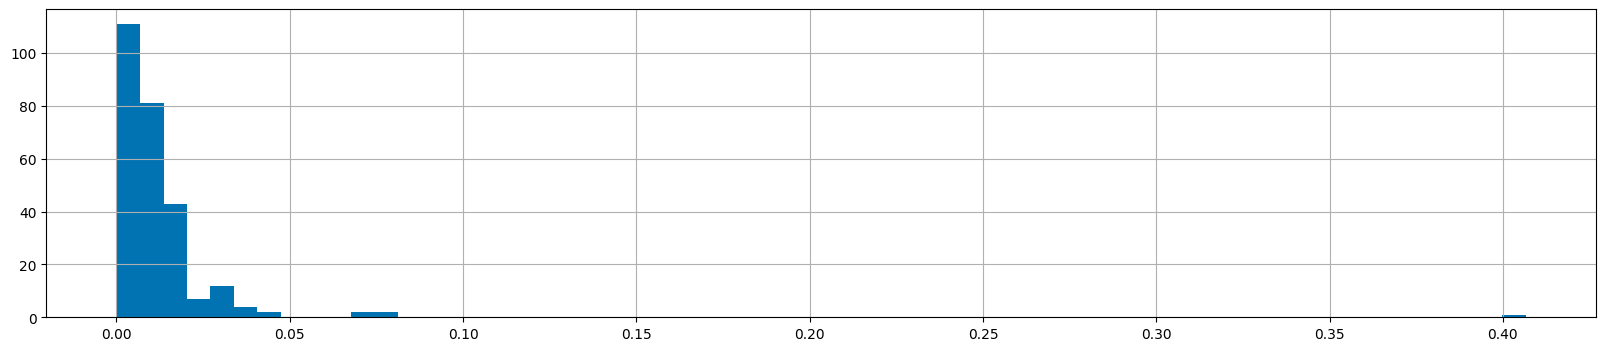

In [13]:
# Coefficient of variation
def coef_of_var(df):
  return df.apply(lambda cell: cell.std() / cell.mean())

CV_orig = coef_of_var(orig)
CV_orig.hist(bins=60, figsize=(20, 4))

## Geomean Difference

In [14]:
mean_orig = orig.apply(lambda cell: cell.mean())
mean_rewr = rewr.apply(lambda cell: cell.mean())
mean_diff = mean_orig - mean_rewr
mean_df = pd.DataFrame({'Mean Diff': mean_diff})

In [15]:
mean_df['Std. Dev.'] = mean_df.apply(lambda c: orig[c.name].std(), axis=1)

### Largest Speedups

In [16]:
mean_df.nlargest(n=20, columns='Mean Diff')

,Mean Diff,Std. Dev.
C_2_10,11158.886879,48.018738
C_8_17,6191.441970,58.202982
C_5_9,3164.089337,42.388038
C_1_18,1640.357471,14.887223
C_7_13,1277.211227,52.841800
C_6_19,1024.354920,16.229899
C_5_22,1008.156062,26.100311
C_6_18,784.091062,14.089235
C_6_14,598.072587,6.903175
C_9_24,538.937951,18.792507


### Largest Slowdowns

In [17]:
largest_abs_slowdowns = mean_df.nsmallest(n=10, columns='Mean Diff')
largest_abs_slowdowns

,Mean Diff,Std. Dev.
C_9_18,-7990.551538,2581.332707
C_15_9,-616.752212,350.154442
C_1_30,-322.449852,39.802125
C_1_27,-264.969663,1.059390
C_4_21,-205.814311,109.181008
C_5_14,-175.034914,10.528305
C_5_11,-115.771639,1.628433
C_17_12,-98.728119,1.998952
C_4_29,-98.087023,74.319835
C_17_5,-67.300952,15.880906


## Relative Speedups

71


<Axes: xlabel='Cells', ylabel='Relative Speedup'>

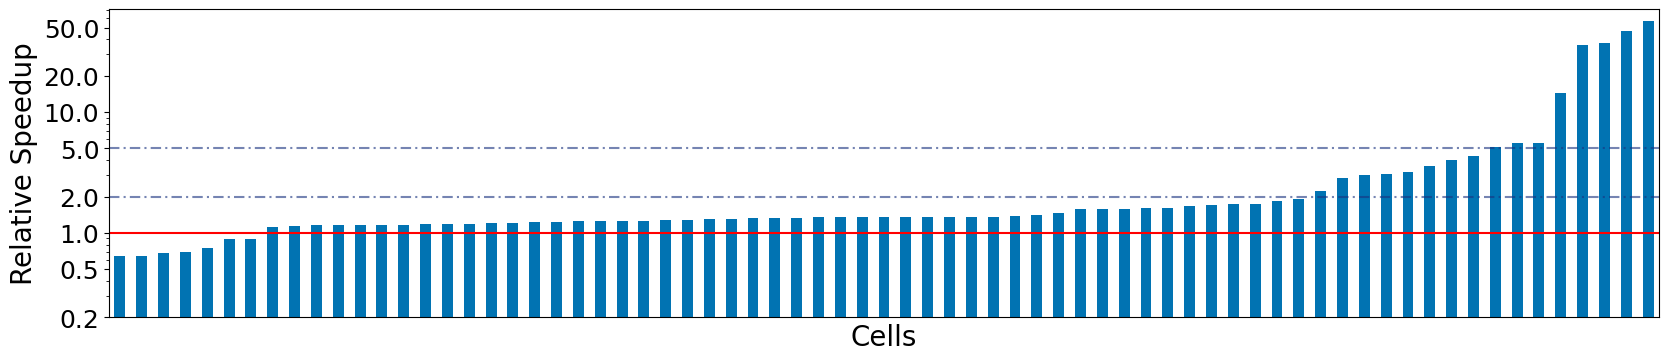

In [18]:
mean_speedup = mean_orig / mean_rewr
mean_speedup = only_hits_cell(mean_speedup)
index_to_nums = mean_speedup.reset_index().drop('index', axis=1)
index_to_nums = index_to_nums.sort_values(by=0)[0]
drop_within_10_perc = index_to_nums.drop(index_to_nums[(0.9 < index_to_nums) & (index_to_nums < 1.1)].index)

print(len(drop_within_10_perc))

thing_to_plot = drop_within_10_perc
ax = thing_to_plot.plot(kind="bar", figsize=(20, 4) )

ax.axhline(1, color='red')
ax.axhline(2, color=(0.1, 0.2, 0.5, 0.6), dashes=(5, 2, 1, 2))
ax.axhline(5, color=(0.1, 0.2, 0.5, 0.6), dashes=(5, 2, 1, 2))

ax.yaxis.set_tick_params(labelsize=18)

ax.set_xlabel("Cells", fontsize=20)
ax.set_ylabel("Relative Speedup", fontsize=20)

ax.set_yscale("log")

ax.set_xticks([])
ax.set_yticks([0.2, 0.5, 1, 2, 5, 10, 20, 50])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.set_xticks([])
plt.savefig(f'{figs_dir}/cell_level.pdf', bbox_inches='tight')
ax

<Axes: xlabel='Cells', ylabel='Relative Speedup'>

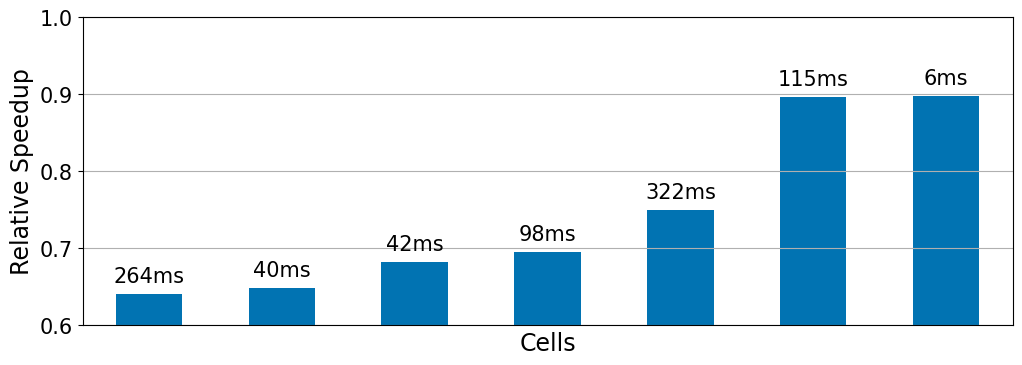

In [19]:
only_cell_slowdowns = mean_speedup.drop(mean_speedup[(0.9 < mean_speedup)].index)
only_cell_slowdowns = only_cell_slowdowns.sort_values()

# ax = only_cell_slowdowns.plot(kind="bar", figsize=(6, 2), color=(56/255, 176/255, 194/255, 1))
# ax = only_cell_slowdowns.plot(kind="bar", figsize=(8, 2), color=(183/255, 19/255, 104/255, 1))
ax = only_cell_slowdowns.plot(kind="bar", figsize=(12, 4))
ax.set_ylabel('Relative Speedup', fontsize=17)
ax.set_xlabel('Cells', fontsize=17)
# ax.axhline(1, color='red')
ax.yaxis.set_tick_params(labelsize=15)
ax.grid(visible=True, axis='y')
plt.ylim(top=1.0, bottom=0.6)
ax.set_xticks([])
ax.set_yticks([x for x in np.arange(0.6, 1.0 + 0.001, 0.1)])

rects = ax.patches

abs_values = [-mean_df.loc[i]['Mean Diff'] for i in only_cell_slowdowns.index]

for rect, label in zip(rects, abs_values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.01, str(int(label)) + "ms", ha="center", va="bottom", fontsize=15
    )


plt.savefig(f'{figs_dir}/cells_only_slowdowns.pdf', bbox_inches='tight', pad_inches=0)
ax

In [20]:
mean_speedup.nlargest(10)

C_9_8     56.434005
C_0_0     46.686228
C_7_0     37.119927
C_8_17    36.155426
C_2_10    14.439058
C_6_19     5.515624
C_6_18     5.511805
C_1_9      5.126495
C_3_0      4.331924
C_14_0     4.035156
dtype: float64

In [21]:
mean_speedup.nsmallest(10)

C_1_27     0.640411
C_1_28     0.647992
C_1_29     0.682809
C_17_12    0.694812
C_1_30     0.749646
C_5_11     0.896888
C_6_8      0.898016
C_16_12    0.910527
C_16_15    0.935089
C_5_14     0.935346
dtype: float64

## Geomean Per-Cell Relative Speedup

In [22]:
stats.gmean(mean_speedup)

1.1820659015666704

## Whole Notebooks

In [23]:
max_nb = max([int(nb.split("_")[1]) for nb in orig.columns])
def get_whole_mean(df):
    nb_means = []
    for i in range(max_nb + 1):
        # All columns (i.e., cells) of the i-th notebook
        col_set = [col for col in df.columns if col.split("_")[1] == str(i)]
        # Sum horizontally. Each element of the resulting Series is one run of the whole notebook
        nb_runs = df[col_set].sum(axis=1)
        # Take the mean (across runs)
        nb_means.append(nb_runs.mean())
    
    return pd.Series(nb_means)

In [24]:
orig_whole = get_whole_mean(orig)
rewr_whole = get_whole_mean(rewr)

<Axes: xlabel='Notebooks', ylabel='Relative Speedup'>

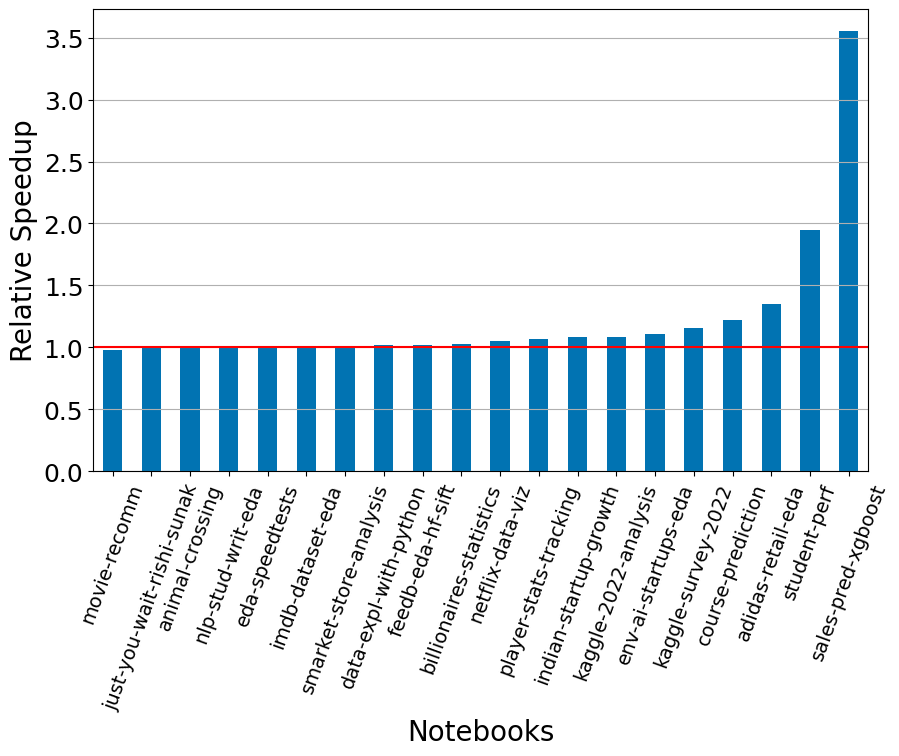

In [25]:
mean_whole_speedup = orig_whole / rewr_whole

mean_whole_speedup = only_hits_nb(mean_whole_speedup)

new_index = []
for nb_idx in mean_whole_speedup.index:
  new_index.append(nb_labels[nb_idx])
mean_whole_speedup.index = pd.Series(new_index)

to_plot_sorted = mean_whole_speedup.sort_values()
ax = to_plot_sorted.plot(kind="bar", figsize=(10, 6) )
ax.set_ylabel('Relative Speedup', fontsize=20)
ax.set_xlabel('Notebooks', fontsize=20)
ax.axhline(1, color='red')
ax.grid(visible=True, axis='y')
ax.yaxis.set_tick_params(labelsize=18)
plt.xticks(rotation=70, fontsize=14)
plt.savefig(f'{figs_dir}/nb_level.pdf', bbox_inches='tight')
ax

In [26]:
mean_whole_speedup.sort_values()

movie-recomm                 0.974532
just-you-wait-rishi-sunak    0.995215
animal-crossing              0.998260
nlp-stud-writ-eda            1.003391
eda-speedtests               1.007206
imdb-dataset-eda             1.010195
smarket-store-analysis       1.010732
data-expl-with-python        1.017785
feedb-eda-hf-sift            1.020132
billionaires-statistics      1.027877
netflix-data-viz             1.052871
player-stats-tracking        1.065363
indian-startup-growth        1.081210
kaggle-2022-analysis         1.081310
env-ai-startups-eda          1.109086
kaggle-survey-2022           1.159023
course-prediction            1.220664
adidas-retail-eda            1.352785
student-perf                 1.947642
sales-pred-xgboost           3.553830
dtype: float64

## Geomean Per-NB Relative Speedup

In [27]:
stats.gmean(mean_whole_speedup)

1.163142827384209

# Compare with Modin

In [28]:
base_less_repl, mem_base = read_stats("stats-rewr_OFF-modin_OFF-repl_LESS-modin_mem_OFF")
rewr_less_repl, mem_rewr = read_stats("stats-rewr_ON-modin_OFF-repl_LESS-modin_mem_OFF")
modin_12, mem_modin12 = read_modin_stats("stats-rewr_OFF-modin_12-repl_LESS-modin_mem_OFF")
modin_8, mem_modin8 = read_modin_stats("stats-rewr_OFF-modin_8-repl_LESS-modin_mem_OFF")
modin_4, mem_modin4 = read_modin_stats("stats-rewr_OFF-modin_4-repl_LESS-modin_mem_OFF")

In [29]:
_mod_mean_base = base_less_repl.apply(lambda cell: cell.mean())
_mod_mean_rewr = rewr_less_repl.apply(lambda cell: cell.mean())
_mod_mean_modin12 = modin_12.apply(lambda cell: cell.mean())
_mod_mean_modin8 = modin_8.apply(lambda cell: cell.mean())
# _mod_mean_modin4 = modin_4.apply(lambda cell: cell.mean())


_mod_rewr_diff = _mod_mean_base - _mod_mean_rewr
_mod_modin12_diff = _mod_mean_base - _mod_mean_modin12
_mod_mean_df = pd.DataFrame({'Mean Rewr': _mod_rewr_diff, 'Mean Modin-12': _mod_modin12_diff})

In [30]:
_mod_mean_df.nlargest(n=10, columns='Mean Modin-12')

,Mean Rewr,Mean Modin-12
C_9_18,-2506.797368,67989.418671
C_16_1,-19.134946,8521.989304
C_7_13,1296.081816,4731.018392
C_0_10,35.787889,4506.288612
C_8_17,6242.235867,3449.606852
C_5_8,63.263030,3178.263602
C_19_15,-12.917920,2794.472060
C_5_14,-196.330659,2428.740041
C_13_14,-22.474461,2388.197588
C_7_8,-2.364877,1456.252973


In [31]:
(_mod_mean_modin12 / _mod_mean_rewr).max()

2143.3279407418963

## Whole Notebooks

In [32]:
_mod_base_whole = get_whole_mean(base_less_repl)
_mod_rewr_whole = get_whole_mean(rewr_less_repl)
_mod_mod12_whole = get_whole_mean(modin_12)
_mod_mod8_whole = get_whole_mean(modin_8)
_mod_mod4_whole = get_whole_mean(modin_4)

<Axes: xlabel='Notebooks', ylabel='Relative Speedup'>

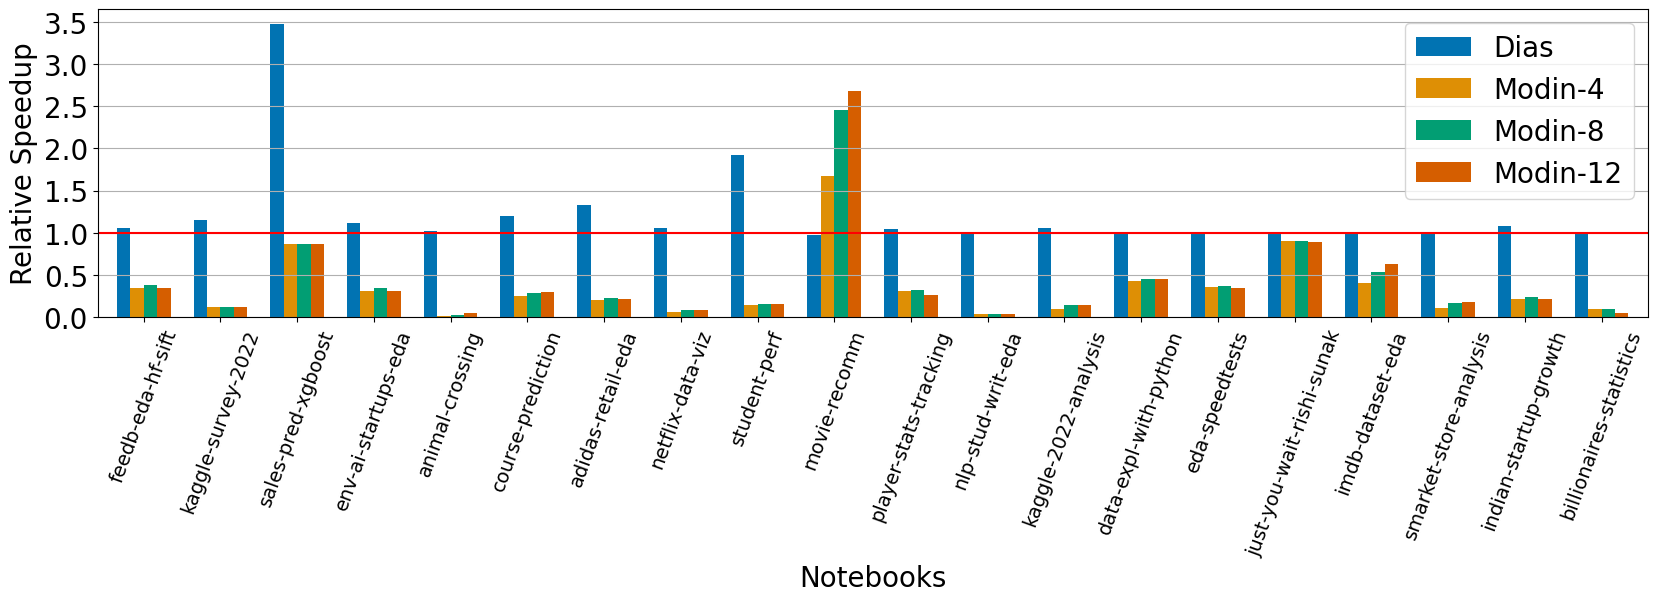

In [33]:
_mod_gmean_rewr_whole_speedup = _mod_base_whole / _mod_rewr_whole
_mod_gmean_mod12_whole_speedup = _mod_base_whole / _mod_mod12_whole
_mod_gmean_mod8_whole_speedup = _mod_base_whole / _mod_mod8_whole
_mod_gmean_mod4_whole_speedup = _mod_base_whole / _mod_mod4_whole
whole_nb_df = pd.DataFrame({'Dias': _mod_gmean_rewr_whole_speedup, 
                            'Modin-4': _mod_gmean_mod4_whole_speedup,
                            'Modin-8': _mod_gmean_mod8_whole_speedup,
                            'Modin-12': _mod_gmean_mod12_whole_speedup
                            })

whole_nb_df = only_hits_nb(whole_nb_df)

new_index = []
for nb_idx in whole_nb_df.index:
  new_index.append(nb_labels[nb_idx])
whole_nb_df = whole_nb_df.set_index(pd.Series(new_index))


ax = whole_nb_df.plot(kind="bar", width=0.7, figsize=(20, 4) )
ax.set_ylabel('Relative Speedup', fontsize=20)
ax.set_xlabel('Notebooks', fontsize=20)
ax.axhline(1, color='red')
ax.set_yticks([x for x in np.arange(0, 3.6, 0.5)])
ax.grid(visible=True, axis='y')
ax.yaxis.set_tick_params(labelsize=20)
ax.legend(fontsize=20)
plt.xticks(rotation=70, fontsize=14)
plt.savefig(f'{figs_dir}/modin_nb.pdf', bbox_inches='tight')
ax

## Summary Numbers vs Modin

In [34]:
speedup_vs_modin = (_mod_mod12_whole / _mod_rewr_whole)

In [35]:
speedup_vs_modin.max()

27.122784625778884

In [36]:
stats.gmean(speedup_vs_modin)

4.928076717839034

# Memory Consumption

In [37]:
mean_mem_base = mem_base.apply(lambda nb: nb.mean())
mean_mem_rewr = mem_rewr.apply(lambda nb: nb.mean())
mean_mem_modin4 = mem_modin4.apply(lambda nb: nb.mean())
rewr_mem_diff = mean_mem_rewr - mean_mem_base
modin4_mem_diff = mean_mem_modin4 - mean_mem_base
mean_mem_df = pd.DataFrame({'SYSTEM': rewr_mem_diff, 'Modin-4': modin4_mem_diff})

In [38]:
# Mem Usage .csv
mean_mem_df = pd.DataFrame({'Pandas': mean_mem_base, 'Modin-4': mean_mem_modin4, 'Dias': mean_mem_rewr})
mean_mem_df.to_csv(f'{figs_dir}/test.csv')

In [39]:
mean_mem_df = only_hits_nb(mean_mem_df)

In [40]:
# Remove those we could not measure
mean_mem_df = mean_mem_df.loc[mean_mem_modin4 != -1]
mean_mem_df

,Pandas,Modin-4,Dias
NB_0,269.3,6176.1,266.8
NB_1,1043.2,4921.0,931.4
NB_2,532.1,0.0,557.0
NB_3,2024.5,3152.5,2037.2
NB_4,2250.0,13161.0,2251.0
NB_5,2821.7,16923.4,2206.9
NB_6,693.0,90665.4,576.6
NB_7,4617.7,107626.8,5660.0
NB_8,568.2,1554.8,566.7
NB_9,4511.1,13445.6,4525.7


In [41]:
# gmean_mem_df['Modin-4'] = 1 - gmean_mem_df['Modin-4']


In [42]:
new_index = []
for nb in mean_mem_df.index:
  nb_idx = int(nb.split('_')[1])
  new_index.append(nb_labels[nb_idx])
mean_mem_df_names = mean_mem_df.set_index(pd.Series(new_index))

for col in mean_mem_df_names.columns:
  mean_mem_df_names[col] = mean_mem_df_names[col] / 1024
mean_mem_df_names

,Pandas,Modin-4,Dias
feedb-eda-hf-sift,0.262988,6.031348,0.260547
kaggle-survey-2022,1.018750,4.805664,0.909570
sales-pred-xgboost,0.519629,0.000000,0.543945
env-ai-startups-eda,1.977051,3.078613,1.989453
animal-crossing,2.197266,12.852539,2.198242
course-prediction,2.755566,16.526758,2.155176
adidas-retail-eda,0.676758,88.540430,0.563086
netflix-data-viz,4.509473,105.104297,5.527344
student-perf,0.554883,1.518359,0.553418
movie-recomm,4.405371,13.130469,4.419629


In [43]:
# Drop this row because we were not able to obtain memory measurements (the memory measurement is 0)
mean_mem_df_names = mean_mem_df_names.drop('sales-pred-xgboost')

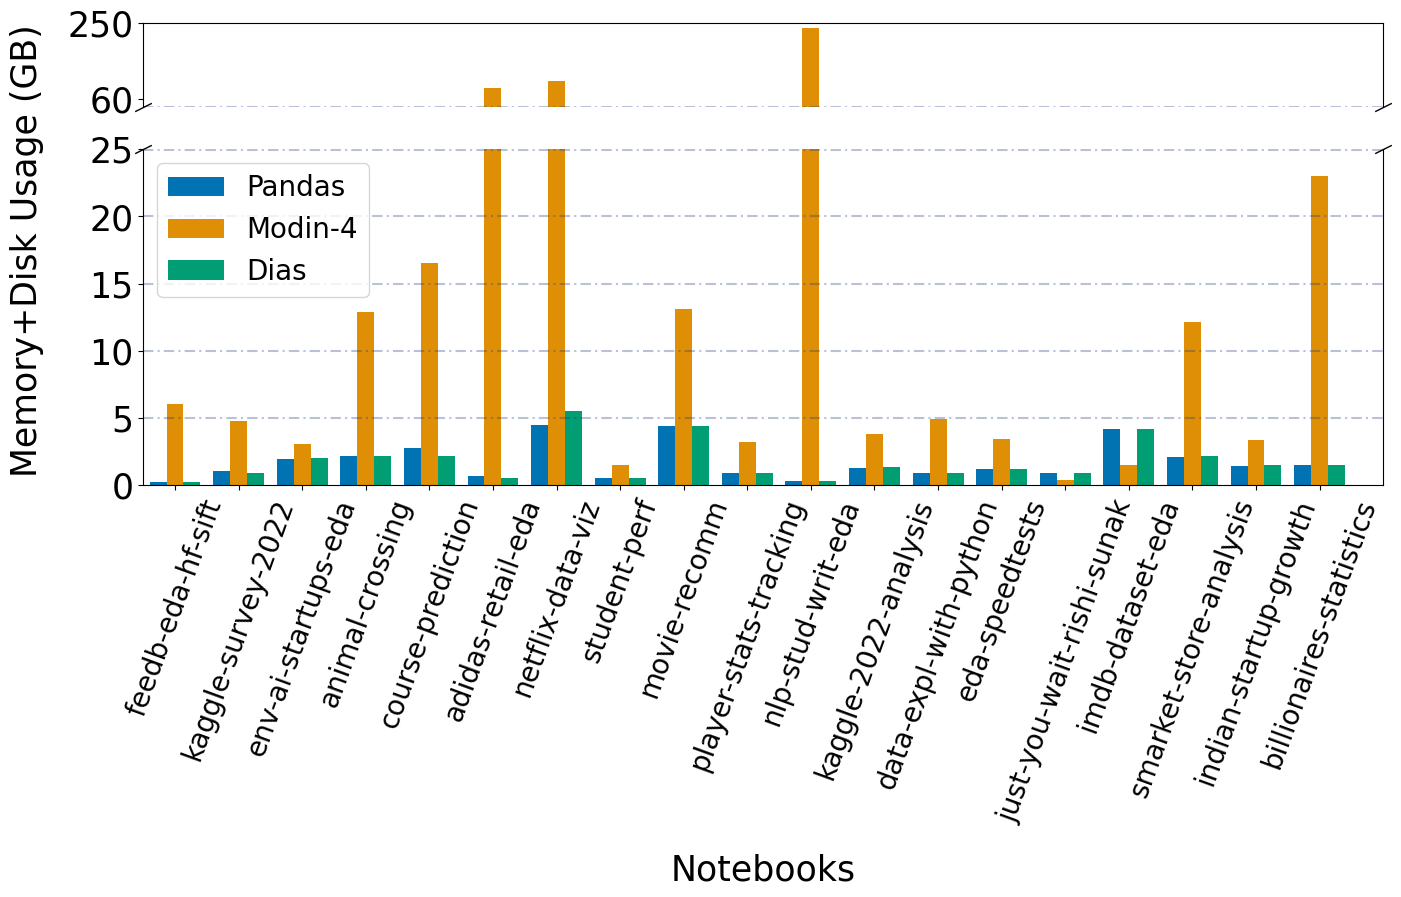

In [44]:
import matplotlib.gridspec as gridspec

nrows = 2
ncols = 1
gs = gridspec.GridSpec(nrows, ncols, height_ratios=[0.2, 0.8])
fig = plt.figure(figsize=(16, 6), dpi=100)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
fig.subplots_adjust(hspace=0.2)

# -.5 otherwise some bars are hidden on the left.
xlim = [-0.5, len(mean_mem_df_names)]
top_y = [40, 90]
bott_y = [0, 20]
ylim = [[], top_y, bott_y]

bar_width = 0.8

# three_colors = [(0.643, 0.424, 0.718, 1), (0.478, 0.643, 0.341, 1), (0.796, 0.416, 0.286, 1)]
# mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax1, legend=False, color=three_colors)
mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax1, legend=False)

ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim[1])
# ax1.grid(color='lightgrey')

# mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax2, legend=True, color=three_colors)
mean_mem_df_names.plot(kind='bar', width=bar_width, ax=ax2, legend=True)
ax2.legend(fontsize=20)
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim[2])
ax2.set_xlabel('Notebooks', labelpad=20, fontsize=25)
ax2.set_ylabel('Memory+Disk Usage (GB)', fontsize=25)
# ax2.grid(color='lightgrey')
ax2.yaxis.set_label_coords(-0.08, 0.7)

ax2.xaxis.set_tick_params(labelsize=20, rotation=70)

ax1.yaxis.set_tick_params(labelsize=25)
ax2.yaxis.set_tick_params(labelsize=25)
# ax2.yaxis.offsetText.set_visible(False)
# ax2.yaxis.get_major_ticks()[0].label1.set_visible(False)
# ax2.ticklabel_format(axis='y', style='sci', scilimits=(6, 6))

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_xticks([])

if APPENDIX_RESUTLS:
  ax1.set_yticks([60, 250])
  ax2.set_yticks([0, 5, 10, 15, 20, 25])

  ax1.axhline(40+0.1, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(25 - 0.1, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(20, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(15, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(10, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(5, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
else:
  ax1.set_yticks([40, 90])
  ax2.set_yticks([0, 5, 10, 20])

  ax1.axhline(40+0.1, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(20 - 0.1, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(10, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))
  ax2.axhline(5, color=(0.1, 0.2, 0.5, 0.3), dashes=(5, 2, 1, 2))

slant = 0.5
kwargs = dict(marker=[(-1, -slant), (1, slant)], markersize=12,
        linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig(f'{figs_dir}/mem_usage.pdf', bbox_inches='tight')

In [45]:
rewr_mem_diff

NB_0       -2.5
NB_1     -111.8
NB_2       24.9
NB_3       12.7
NB_4        1.0
NB_5     -614.8
NB_6     -116.4
NB_7     1042.3
NB_8       -1.5
NB_9       14.6
NB_10      -0.5
NB_11       0.8
NB_12      55.1
NB_13       0.0
NB_14       1.5
NB_15       0.6
NB_16       0.9
NB_17      63.7
NB_18      41.3
NB_19       0.8
dtype: float64

In [46]:
rewr_mem_diff['NB_7']

1042.3000000000002

# Rewriter Stats

In [47]:
cell_rewr_stats = dict()
version = "stats-rewr_ON-modin_OFF-repl_STD-modin_mem_OFF"
for nb_idx, nb in enumerate(nbs):
  for r in range(num_runs):
    nb_filename = '_'.join(nb.split('/')) + '.json'
    filepath = f"{pwd}/{version}/s-{r}/{nb_filename}"
    fp = open(filepath, 'r')
    d = json.load(fp)
    fp.close()
    for c_idx, c in enumerate(d['cells']):
      key = f"C_{nb_idx}_{c_idx}"
      try:
        cell_rewr_stats[key].append(c)
      except:
        cell_rewr_stats[key] = [c]

## How Many Patterns We Needed

In [48]:
patts_needed = set()
for cell_key in cell_rewr_stats:
  cell = cell_rewr_stats[cell_key]
  for run in cell:
    patts_needed |= set(run['patts-hit'].keys())

len(patts_needed)

10

## Max and Mean Absolute Overheads (in any run)

In [49]:
# NOTE: We find the max overhead _in any run_, not means.

all_ohs = []
for cell_key in cell_rewr_stats:
  cell = cell_rewr_stats[cell_key]
  for run in cell:
    oh = ns_to_ms(run['overhead-ns'])
    all_ohs.append(oh)

max_oh = max(all_ohs)
print(f"Maximum Overhead: {max_oh: .2f}ms")
mean_oh = stats.gmean(all_ohs)
print(f"GMean Overhead: {mean_oh: .2f}ms")

Maximum Overhead:  22.77ms
GMean Overhead:  0.41ms


## Do we every slow down a rewritten cell (beyond interactive latency) ?

In [50]:
# Pretty small value for interactive latency
interactive_latency = 10
slowdown_rewr_cell = False

# Go through each cell in the stats. If we hit on this cell, then check the
# original stats and see if there's a difference outside the interactive
# latency.
for cell_key in cell_rewr_stats:
  if cell_key not in orig.columns:
    # Dropped as very fast. Skip
    continue
  # Get only one run. If we hit, we hit in all the runs.
  cell = cell_rewr_stats[cell_key][0]
  if cell['patts-hit'] != {}:
    diff = mean_rewr[cell_key] - mean_orig[cell_key]
    if diff > interactive_latency:
      print(f"Slowdown: {diff: .2f}")
      slowdown_rewr_cell = True

if not slowdown_rewr_cell:
  print("NO!")

NO!
